# DO NOT 'RUN ALL CELLS'

In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
import os.path
import glob

import math
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [2]:
folder = ["training", "test"]

In [3]:
#resize all images in a folder to 64 by 64
def image_resize(folder):
    images = glob.glob("img/" + folder + "/*.jpg")
    for image in images:
        im_path = os.path.abspath(image)
        im = Image.open(im_path)
        im = im.resize((64, 64), Image.ANTIALIAS)
        im.save(os.path.splitext(im_path)[0] + '-small.jpg')

## only need to run this if starting new project
# for f in folder:
#     image_resize(f)

In [4]:
# convert image to tensor
def convert_to_tensor(folder):
    x = np.empty((0, 64, 64, 3))
    y = np.empty((0, 2))
    directory_name = "img/" + folder
    for filename in os.listdir(directory_name):
        if filename.endswith("-small.jpg"):
            img = Image.open(os.path.join(directory_name, filename)).convert('RGB')
            x = np.append(x, np.array(img).reshape((1, 64, 64, 3)), axis = 0)
            if filename.startswith('owl'):
                y = np.append(y, np.array([1, 0]).reshape((1, 2)), axis = 0)
#                 print(filename)
#                 print(y[-1])
            else: 
                y = np.append(y, np.array([0, 1]).reshape((1, 2)), axis = 0)
#                 print(filename)
#                 print(y[-1])
    return [x, y]
    
xtrain, ytrain = convert_to_tensor(folder[0])
xtest, ytest = convert_to_tensor(folder[1])

In [5]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(30, 64, 64, 3)
(30, 2)
(10, 64, 64, 3)
(10, 2)


In [6]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    #Creates the placeholders for the tensorflow session.
    #n_H0 -- scalar, height of an input image
    #n_W0 -- scalar, width of an input image
    #n_C0 -- scalar, number of channels of the input
    #n_y -- scalar, number of classes
        
    #Returns:
    #X -- placeholder for the data input
    #Y -- placeholder for the input labels
    
    X = tf.placeholder(dtype = "float", shape = (None,n_H0,n_W0,n_C0), name='input')
    Y = tf.placeholder(dtype = "float", shape = (None,n_y))
    
    return X, Y

In [8]:
def initialize_parameters():
    
    #Initializes weight parameters to build a neural network with tensorflow. The shapes are:
    #                   W1 : [4, 4, 3, 8]
    #                   W2 : [2, 2, 8, 16]
    #Returns:
    #parameters -- a dictionary of tensors containing W1, W2
    
    tf.set_random_seed(1)                           
        
    W1 = tf.get_variable("W1", [4,4,3,8],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2,2,8,16],initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1, "W2": W2}
    
    return parameters

In [13]:
def forward_propagation(X, parameters):

    #Implements the forward propagation for the model:
    #CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    #X -- input dataset placeholder
    #parameters -- python dictionary containing parameters "W1", "W2"

    #Returns:
    #Z3 -- the output of the last LINEAR unit
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')

    A1 = tf.nn.relu(Z1)
    
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')

    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')

    A2 = tf.nn.relu(Z2)

    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')

    P2 = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(P2, 2, activation_fn=None)

    return Z3

In [10]:
def compute_cost(Z3, Y):

    #Computes the cost
    
    #Z3 -- output of forward propagation (output of the last LINEAR unit)
    #Y -- real labels vector placeholder
    
    #Returns:
    #cost - Tensor of the cost function

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y),0)
    
    return cost

In [14]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
          num_epochs=30, minibatch_size=2, print_cost=True):

    #Implements a three-layer ConvNet in Tensorflow:
    #CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    #X_train -- training set, of shape (None, 64, 64, 3)
    #Y_train -- test set, of shape (None, n_y = 2)
    #X_test -- training set, of shape (None, 64, 64, 3)
    #Y_test -- test set, of shape (None, n_y = 2)
    #learning_rate -- learning rate of the optimization
    #num_epochs -- number of epochs of the optimization loop
    #minibatch_size -- size of a minibatch
    #print_cost -- True to print the cost every 100 epochs
    
    #train_accuracy -- real number, accuracy on the train set (X_train)
    #test_accuracy -- real number, testing accuracy on the test set (X_test)
    #parameters -- parameters learnt by the model. They can then be used to predict.
    
    # to be able to rerun the model without overwriting tf variables
    ops.reset_default_graph()                         
    # to keep results consistent (tensorflow seed)
    tf.set_random_seed(1)                             
    # to keep results consistent (numpy seed)
    seed = 3                                          
    
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1, name='output')
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        # check which test images identification result
        predict_result = predict_op.eval({X: X_test, Y: Y_test})
        print("result:", predict_result)
        
        # Save model to ckpt so it can be used for prediction later
        saver = tf.train.Saver()
        save_path = saver.save(sess, "./model.ckpt")
        print("Model saved in path: %s" % save_path)
        
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 29.798349
Cost after epoch 5: 0.834895
Cost after epoch 10: 0.139745
Cost after epoch 15: 0.164987
Cost after epoch 20: 0.218398
Cost after epoch 25: 0.077484


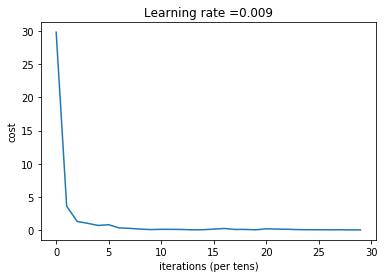

Train Accuracy: 1.0
Test Accuracy: 1.0
result: [1 1 1 1 1 0 0 0 0 0]
Model saved in path: ./model.ckpt
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
_, _, parameters = model(xtrain, ytrain, xtest, ytest)
print(ytest)

In [ ]:
#make sure all 30 input images are labeled correctly when imported - checked
#view all images in test set that has been identified as owl - checked
#add 10 images to training and 6 to test set - TBD
#make prediction on new image with manual test - checked